## Analysis of The Driving Hamiltonian

#### Imports

In [37]:
from collections import Counter
from src.hamiltonian_utils import get_twobody_nuclearshell_model,FermiHubbardHamiltonian,SingleParticleState
import numpy as np
import torch
from typing import Dict
from src.qml_models import AdaptVQEFermiHubbard
from src.qml_utils.train import Fit
from src.qml_utils.utils import configuration
from scipy.sparse.linalg import eigsh,expm_multiply
from tqdm import trange
import matplotlib.pyplot as plt
import scipy

def plot_spectrum(eigenvalues):
    """
    Plot the vertical spectrum of a Hamiltonian, showing the eigenvalues as horizontal lines 
    and indicating their degeneracy.

    Parameters:
    eigenvalues (array-like): Array of eigenvalues of the Hamiltonian.
    """
    # Count the degeneracy of each eigenvalue
    degeneracy = Counter(eigenvalues)

    # Prepare data for plotting
    unique_eigenvalues = list(degeneracy.keys())
    degeneracies = list(degeneracy.values())

    # Plot the spectrum
    plt.figure(figsize=(6, 10))
    for i, (eig, deg) in enumerate(zip(unique_eigenvalues, degeneracies)):
        plt.hlines(eig, i - 0.2 * deg, i + 0.2 * deg, colors='b', linewidth=5)
        plt.text(i, eig, f'{deg}', horizontalalignment='center', verticalalignment='bottom', fontsize=24, color='r')

    # Make the plot fancy
    plt.title('Spectrum of the Hamiltonian', fontsize=16)
    plt.ylabel('Eigenvalue', fontsize=14)
    plt.xlabel('Index (degeneracy indicated by text)', fontsize=14)
    plt.xticks(range(len(unique_eigenvalues)), ['']*len(unique_eigenvalues))  # Remove x-axis ticks
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()

    # Show the plot
    plt.show()

file_name='data/usdb.nat'
SPS=SingleParticleState(file_name=file_name)
energies=SPS.energies

#### Hyperparameters

In [38]:
nparticles_a=4
nparticles_b=4

size_a=SPS.energies.shape[0]//2
size_b=SPS.energies.shape[0]//2




J and M operator and the single particle Basis

In [39]:
matrix_j,_=get_twobody_nuclearshell_model(file_name='data/j2.int')

energies=SPS.energies

diag_j=np.zeros(energies.shape[0])
diag_m=np.zeros(energies.shape[0])
label=[]
for i in range(energies.shape[0]):
    n,l,j,m,_,tz=SPS.state_encoding[i]
    label.append((j,m,tz))
    diag_j[i]=j*(j+1)
    diag_m[i]=m

Joperator = FermiHubbardHamiltonian(
    size_a=size_a,
    size_b=size_b,
    nparticles_a=nparticles_a,
    nparticles_b=nparticles_b,
)

Joperator.get_twobody_interaction(twobody_dict=matrix_j)
Joperator.get_external_potential(diag_j)
Joperator.get_hamiltonian()

Jdiagoperator=FermiHubbardHamiltonian(
    size_a=size_a,
    size_b=size_b,
    nparticles_a=nparticles_a,
    nparticles_b=nparticles_b,
)

Jdiagoperator.get_external_potential(diag_j)
Jdiagoperator.get_hamiltonian()


Moperator = FermiHubbardHamiltonian(
    size_a=size_a,
    size_b=size_b,
    nparticles_a=nparticles_a,
    nparticles_b=nparticles_b,
)

Moperator.get_external_potential(diag_m)
Moperator.get_hamiltonian()


Computing the matrix, pls wait... (u_u) 



100%|██████████| 12/12 [00:01<00:00,  7.35it/s]


KeyboardInterrupt: 

#### Target Hamiltonian

In [ ]:
twobody_matrix,energies=get_twobody_nuclearshell_model(file_name=file_name)

iso_dict={-0.5:'n',0.5:'p'}
values=np.asarray(list(twobody_matrix.values()))
print(np.average(np.abs(values)))
for key in twobody_matrix.keys():
    i,j,k,l=key
    (n,_,ja,ma,_,tza)=SPS.state_encoding[i]
    (n,_,jb,mb,_,tzb)=SPS.state_encoding[j]
    (n,_,jc,mc,_,tzc)=SPS.state_encoding[k]
    (n,_,jd,md,_,tzd)=SPS.state_encoding[l]

    print(ja,ma,iso_dict[tza]+'+'+iso_dict[tzb],jb,mb,'-->',jc,mc,iso_dict[tzc]+'+'+iso_dict[tzd],jd,md)
    print('cross section=',twobody_matrix[key],'\n')
    

average_unit_energy=np.average(np.abs(np.asarray(list(twobody_matrix.values()))))

Computing the matrix, pls wait... (u_u) 



100%|██████████| 24/24 [01:31<00:00,  3.79s/it]


0.47885756477481256
2.5 -2.5 p+p 2.5 -1.5 --> 2.5 -2.5 p+p 2.5 -1.5
cross section= -0.20690000000000003 

2.5 -2.5 p+p 2.5 -1.5 --> 2.5 -1.5 p+p 2.5 -2.5
cross section= 0.20690000000000003 

2.5 -1.5 p+p 2.5 -2.5 --> 2.5 -2.5 p+p 2.5 -1.5
cross section= 0.20690000000000003 

2.5 -1.5 p+p 2.5 -2.5 --> 2.5 -1.5 p+p 2.5 -2.5
cross section= -0.20690000000000003 

2.5 -2.5 p+p 2.5 -1.5 --> 2.5 -2.5 p+p 1.5 -1.5
cross section= 1.3349000000000004 

2.5 -2.5 p+p 2.5 -1.5 --> 1.5 -1.5 p+p 2.5 -2.5
cross section= -1.3349000000000004 

2.5 -1.5 p+p 2.5 -2.5 --> 2.5 -2.5 p+p 1.5 -1.5
cross section= -1.3349000000000004 

2.5 -1.5 p+p 2.5 -2.5 --> 1.5 -1.5 p+p 2.5 -2.5
cross section= 1.3349000000000004 

2.5 -2.5 p+p 2.5 -0.5 --> 2.5 -2.5 p+p 2.5 -0.5
cross section= -0.20690000000000003 

2.5 -2.5 p+p 2.5 -0.5 --> 2.5 -0.5 p+p 2.5 -2.5
cross section= 0.20690000000000003 

2.5 -0.5 p+p 2.5 -2.5 --> 2.5 -2.5 p+p 2.5 -0.5
cross section= 0.20690000000000003 

2.5 -0.5 p+p 2.5 -2.5 --> 2.5 -0.5 p+p 2.5 -

In [41]:
nlevels=1
TargetHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
print('size=',size_a+size_b,size_b)
TargetHamiltonian.get_external_potential(external_potential=energies[:size_a+size_b])
print('get the two body interaction...')
#TargetHamiltonian.get_twobody_interaction(twobody_dict=twobody_matrix)
TargetHamiltonian.twobody_operator=scipy.sparse.load_npz(f'data/nuclear_twobody_matrix/usdb_{nparticles_a}_{nparticles_b}.npz')
TargetHamiltonian.get_hamiltonian()

print('get the eigenvalue problem...')
egs,psis=TargetHamiltonian.get_spectrum(n_states=1)

print(egs)

print(TargetHamiltonian.twobody_operator)



Moperator = FermiHubbardHamiltonian(
    size_a=size_a,
    size_b=size_b,
    nparticles_a=nparticles_a,
    nparticles_b=nparticles_b,
)


size= 24 12
get the two body interaction...
get the eigenvalue problem...
[-92.77520307]
  (0, 0)	-35.72343017857143
  (0, 1)	0.10435216049167698
  (0, 2)	0.8598999999999996
  (0, 3)	0.3596601225771707
  (0, 4)	-0.19837717572588723
  (0, 5)	0.10165680416643712
  (0, 6)	-0.6918637014569978
  (0, 7)	0.0683045371787489
  (0, 8)	-0.2530987765796636
  (0, 9)	-0.4546230489830741
  (0, 10)	0.4237229179758751
  (0, 11)	-0.10165680416643709
  (0, 13)	-0.6918637014569978
  (0, 15)	-0.19515286510161337
  (0, 16)	-0.14860413794393482
  (0, 17)	-1.087278158001068
  (0, 18)	0.23293633710277387
  (0, 19)	-0.6489247535071269
  (0, 20)	0.9007818899896537
  (0, 21)	0.09673599074161547
  (0, 22)	0.09673599074161547
  (0, 23)	-1.3995613925794361
  (0, 24)	-0.07222039837222677
  (0, 25)	0.1274540877860897
  (0, 26)	-1.5803666666666671
  :	:
  (28502, 28467)	0.1295371825641837
  (28502, 28468)	0.25907436512836757
  (28502, 28469)	6.938893903907228e-17
  (28502, 28474)	1.7984746068253417
  (28502, 28475)	-0.

particle distribution

In [25]:
n_expectation_nsmodel=np.zeros((nlevels,size_a+size_b))

for j in range(nlevels):
    for i in range(size_a+size_b):
        
        op=InitialHamiltonian.adag_a_matrix(i=i,j=i)
        n_expectation_nsmodel[j,i]=( (psis[:,j].conjugate().transpose() @ op @ psis[:,j]))



NameError: name 'InitialHamiltonian' is not defined

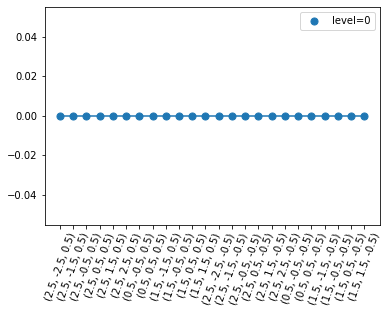

0.0


In [26]:
for i in range(1):
    plt.plot(n_expectation_nsmodel[i])
    plt.scatter(np.arange(energies.shape[0]),n_expectation_nsmodel[i],s=50,label=f'level={i}')
    plt.xticks(np.arange(energies.shape[0]),label,rotation=70)
plt.legend()
plt.show()

print(np.sum(n_expectation_nsmodel))

##### Correlation Matrix

In [ ]:
correlation_matrix=np.zeros((size_a+size_b,size_a+size_b))
for i in range(size_a):
    for j in range(size_a):
        op=TargetHamiltonian.adag_a_matrix(i=i,j=j)
        correlation_matrix[j,i]=( (psis[:,0].conjugate().transpose() @ op @ psis[:,0]))
        
for i in range(size_a,size_a+size_b):
    for j in range(size_a,size_a+size_b):
        op=TargetHamiltonian.adag_a_matrix(i=i,j=j)
        correlation_matrix[j,i]=( (psis[:,0].conjugate().transpose() @ op @ psis[:,0]))

Plot

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23]),
 [Text(0, 0, '(2.5, -2.5, 0.5)'),
  Text(1, 0, '(2.5, -1.5, 0.5)'),
  Text(2, 0, '(2.5, -0.5, 0.5)'),
  Text(3, 0, '(2.5, 0.5, 0.5)'),
  Text(4, 0, '(2.5, 1.5, 0.5)'),
  Text(5, 0, '(2.5, 2.5, 0.5)'),
  Text(6, 0, '(0.5, -0.5, 0.5)'),
  Text(7, 0, '(0.5, 0.5, 0.5)'),
  Text(8, 0, '(1.5, -1.5, 0.5)'),
  Text(9, 0, '(1.5, -0.5, 0.5)'),
  Text(10, 0, '(1.5, 0.5, 0.5)'),
  Text(11, 0, '(1.5, 1.5, 0.5)'),
  Text(12, 0, '(2.5, -2.5, -0.5)'),
  Text(13, 0, '(2.5, -1.5, -0.5)'),
  Text(14, 0, '(2.5, -0.5, -0.5)'),
  Text(15, 0, '(2.5, 0.5, -0.5)'),
  Text(16, 0, '(2.5, 1.5, -0.5)'),
  Text(17, 0, '(2.5, 2.5, -0.5)'),
  Text(18, 0, '(0.5, -0.5, -0.5)'),
  Text(19, 0, '(0.5, 0.5, -0.5)'),
  Text(20, 0, '(1.5, -1.5, -0.5)'),
  Text(21, 0, '(1.5, -0.5, -0.5)'),
  Text(22, 0, '(1.5, 0.5, -0.5)'),
  Text(23, 0, '(1.5, 1.5, -0.5)')])

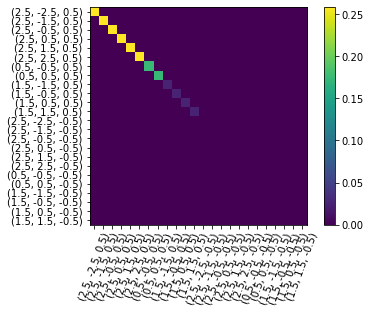

In [ ]:
plt.imshow(correlation_matrix)
plt.colorbar()
plt.xticks(np.arange(energies.shape[0]),label,rotation=70)
plt.yticks(np.arange(energies.shape[0]),label)
plt.xticks()

#### Case a: Driver Hamiltonian A

In [46]:
omega=3

t=omega
w=omega
h=omega


In [366]:
InitialHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b)

kinetic_term:Dict={}
adj_matrix=np.zeros((size_a+size_b,size_a+size_b))

#cki
j_values=[1/2,3/2]

print(t,w)


mj_list=[]
for j in j_values:
    m_values=-2*j+2*np.arange(0,int(2*j)+1)
    
    m_values=m_values[m_values>0.]
    for m in m_values:
        mj_list.append((m/2,j,1))

for tzi in [-1/2,1/2]:
    
    for f,tupi in enumerate(mj_list):
        mi,ji,ni=tupi
        #mj,jj,nj=mj_list[(f+1)% len(mj_list)]
        for tupj in mj_list:
            mj,jj,nj=tupj
            if mi!=mj:
                print(mi,mj)
                continue
            if ji==jj:
                continue
            print('otherwise=',mi,mj)
            #if ni==nj:
            i=SPS.get_index((ni,0,ji,mi,1/2,tzi))
            k=SPS.get_index((ni,0,ji,-1*mi,1/2,tzi))
            j=SPS.get_index((nj,0,jj,mj,1/2,tzi))
            l=SPS.get_index((nj,0,jj,-1*mj,1/2,tzi))
            kinetic_term[(i,j)]=(t/2+w/2) #np.abs(mi-mj)#+np.abs(ji-jj)
            adj_matrix[i,j]=(t/2+w/2)#np.abs(mi-mj)#+np.abs(ji-jj)
            kinetic_term[(j,i)]=(t/2+w/2) #np.abs(mi-mj)#+np.abs(ji-jj)
            adj_matrix[j,i]=(t/2+w/2)#np.abs(mi-mj)#+np.abs(ji-jj)
            
            kinetic_term[(i,l)]=(t/2-w/2) #np.abs(mi-mj)#+np.abs(ji-jj)
            adj_matrix[i,l]=(t/2-w/2)#np.abs(mi-mj)#+np.abs(ji-jj)
            kinetic_term[(l,i)]=(t/2-w/2) #np.abs(mi-mj)#+np.abs(ji-jj)
            adj_matrix[l,i]=(t/2-w/2)#np.abs(mi-mj)#+np.abs(ji-jj)
            
            kinetic_term[(k,j)]=(t/2-w/2) #np.abs(mi-mj)#+np.abs(ji-jj)
            adj_matrix[k,j]=(t/2-w/2)#np.abs(mi-mj)#+np.abs(ji-jj)
            kinetic_term[(j,k)]=(t/2-w/2) #np.abs(mi-mj)#+np.abs(ji-jj)
            adj_matrix[j,k]=(t/2-w/2)#np.abs(mi-mj)#+np.abs(ji-jj)
            
            kinetic_term[(k,l)]=(t/2+w/2) #np.abs(mi-mj)#+np.abs(ji-jj)
            adj_matrix[k,l]=(t/2+w/2)#np.abs(mi-mj)#+np.abs(ji-jj)
            
            kinetic_term[(l,k)]=(t/2+w/2) #np.abs(mi-mj)#+np.abs(ji-jj)
            adj_matrix[l,k]=(t/2+w/2)#np.abs(mi-mj)#+np.abs(ji-jj)
        


                
external_field=np.zeros(size_a+size_b)
rand=np.random.uniform(0,1,3)
rand_dict={1/2:rand[0],-1/2:rand[1]}
for i in range(size_a+size_b):
    (ni,li,ji,mi,ti,tzi)=SPS.state_encoding[i]
    j=SPS.get_index((ni,li,ji,-mi,ti,tzi))
    external_field[i]=h*(ji)


    
    #external_field[i] = SPS.energies[i]


InitialHamiltonian.get_kinetic_operator(adj_matrix=kinetic_term)
InitialHamiltonian.get_external_potential(external_field)
InitialHamiltonian.get_hamiltonian()

nlevels=8

es,psis=InitialHamiltonian.get_spectrum(n_states=nlevels)
einitial=es[0]
psi_initial=psis[:,0]
print('total_m=',SPS.compute_m_exp_value(psi=psi_initial,basis=InitialHamiltonian.basis))
print('total J^2=',psi_initial.transpose().conjugate() @ Joperator.hamiltonian @ psi_initial)
plt.figure(figsize=(10,10))

plt.title(r'$A_{ij}$ where $H_0=\sum_{ij}A_{ij} c^{\dagger}_i c_j + h \sum_i j_i \hat{n}_i$',fontsize=20)
plt.imshow(adj_matrix)
plt.xticks(np.arange(diag_m.shape[0]),label,rotation=70)
plt.yticks(np.arange(diag_m.shape[0]),label)
plt.colorbar()
plt.savefig('images/fig4')
plt.tick_params(which='major',labelsize=20)
plt.axhline(y=energies.shape[0]//2-0.5,color='red',linestyle='--')
plt.axvline(x=energies.shape[0]//2-0.5,color='red',linestyle='--')

plt.axhline(y=energies.shape[0]-5.5,color='green',linestyle='--')
plt.axvline(x=energies.shape[0]-5.5,color='green',linestyle='--')


plt.axhline(y=energies.shape[0]-8.5,color='green',linestyle='--')
plt.axvline(x=energies.shape[0]-8.5,color='green',linestyle='--')

plt.show()

print(einitial)

#print(InitialHamiltonian.hamiltonian)
print('m value=',Moperator.hamiltonian @ InitialHamiltonian.hamiltonian- InitialHamiltonian.hamiltonian @ Moperator.hamiltonian)

3 3
otherwise= 0.5 0.5


ValueError: (1, 0, 1.5, 0.5, 0.5, -0.5) is not in list

####  Driver Hamiltonian B

total_m= 1.5543122344752192e-15


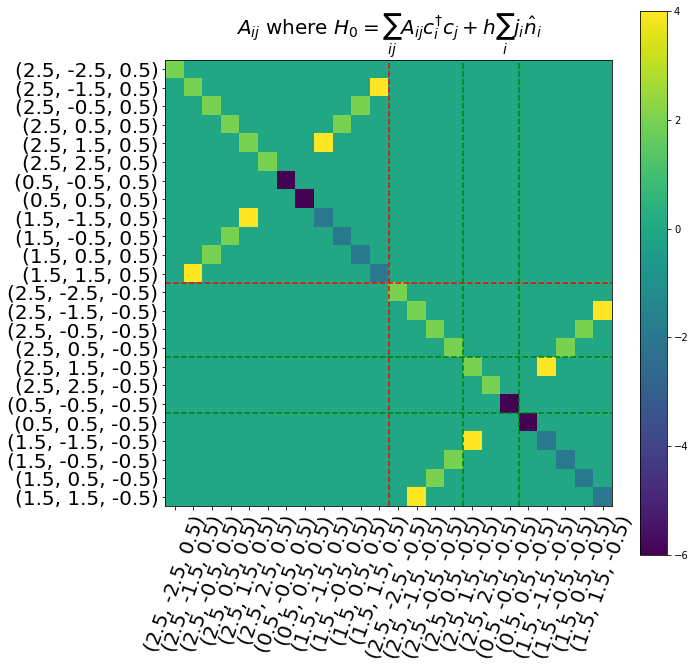

-26.60112615949155


In [207]:
omega=4
omega_b=2

InitialHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b)

kinetic_term:Dict={}
adj_matrix=np.zeros((size_a+size_b,size_a+size_b))

#cki
j_values=[1/2,3/2]


mj_list=[]
for a in range(energies.shape[0]):
    for b in range(energies.shape[0]):
        (na,la,ja,ma,ta,tza)=SPS.state_encoding[a]
        (nb,lb,jb,mb,tb,tzb)=SPS.state_encoding[b]
        
        # if ja==1.5 and ma==0.5 and jb==0.5 and mb==-0.5 and tza==tzb:
        #     kinetic_term[(a,b)]=omega
        #     kinetic_term[(b,a)]=omega
        #     adj_matrix[a,b]=omega
        #     adj_matrix[b,a]=omega
        
        # if ja==0.5 and ma==0.5 and jb==1.5 and mb==-0.5 and tza==tzb:
        #     kinetic_term[(a,b)]=omega
        #     kinetic_term[(b,a)]=omega
        #     adj_matrix[a,b]=omega
        #     adj_matrix[b,a]=omega
        
        if ja==2.5 and ma==1.5 and jb==1.5 and mb==-1.5 and tza==tzb:
            kinetic_term[(a,b)]=omega
            kinetic_term[(b,a)]=omega
            adj_matrix[a,b]=omega
            adj_matrix[b,a]=omega

        if ja==1.5 and ma==1.5 and jb==2.5 and mb==-1.5 and tza==tzb:
            kinetic_term[(a,b)]=omega
            kinetic_term[(b,a)]=omega
            adj_matrix[a,b]=omega
            adj_matrix[b,a]=omega

        if ja==2.5 and ma==0.5 and jb==1.5 and mb==-0.5 and tza==tzb:
            kinetic_term[(a,b)]=omega_b
            kinetic_term[(b,a)]=omega_b
            adj_matrix[a,b]=omega_b
            adj_matrix[b,a]=omega_b

        if ja==1.5 and ma==0.5 and jb==2.5 and mb==-0.5 and tza==tzb:
            kinetic_term[(a,b)]=omega_b
            kinetic_term[(b,a)]=omega_b
            adj_matrix[a,b]=omega_b
            adj_matrix[b,a]=omega_b


                
external_field=np.zeros(size_a+size_b)
rand=np.random.uniform(0,1,3)
rand_dict={1/2:rand[0],-1/2:rand[1]}
for i in range(size_a+size_b):
    (ni,li,ji,mi,ti,tzi)=SPS.state_encoding[i]
    j=SPS.get_index((ni,li,ji,-mi,ti,tzi))
    external_field[i]=ji*omega-2*omega
    # if ji==1.5 and (mi)==0.5:
    #     external_field[i]=0
    # if ji==0.5 and (mi)==-0.5:
    #     external_field[i]=0
        
    # if ji==1.5 and (mi)==-0.5:
    #     external_field[i]=0
    # if ji==0.5 and (mi)==0.5:
    #     external_field[i]=0
        
    # if ji==1.5 and mi==1.5:
    #     external_field[i]=0
        
    # if ji==1.5 and mi==-1.5:
    #     external_field[i]=0
        
    # if ji==2.5 and mi==1.5:
    #     external_field[i]=0
        
    # if ji==2.5 and mi==-1.5:
    #     external_field[i]=0
    
    # if ji==1.5 and mi==0.5:
    #     external_field[i]=0
        
    # if ji==1.5 and mi==-0.5:
    #     external_field[i]=0
        
    # if ji==2.5 and mi==0.5:
    #     external_field[i]=0
        
    # if ji==2.5 and mi==-0.5:
    #     external_field[i]=0
        
    # if ji==2.5 and np.abs(mi)==2.5:
    #     external_field[i]=omega_c

        
        
    
        
    

    
    #external_field[i] = SPS.energies[i]


InitialHamiltonian.get_kinetic_operator(adj_matrix=kinetic_term)
InitialHamiltonian.get_external_potential(external_field)
InitialHamiltonian.get_hamiltonian()

nlevels=8

es,psis=InitialHamiltonian.get_spectrum(n_states=nlevels)
einitial=es[0]
psi_initial=psis[:,0]
print('total_m=',SPS.compute_m_exp_value(psi=psi_initial,basis=InitialHamiltonian.basis))
#print('total J^2=',psi_initial.transpose().conjugate() @ Joperator.hamiltonian @ psi_initial)
plt.figure(figsize=(10,10))

plt.title(r'$A_{ij}$ where $H_0=\sum_{ij}A_{ij} c^{\dagger}_i c_j + h \sum_i j_i \hat{n}_i$',fontsize=20)
plt.imshow(adj_matrix+np.eye(energies.shape[0])*external_field[None,:])
plt.xticks(np.arange(diag_m.shape[0]),label,rotation=70)
plt.yticks(np.arange(diag_m.shape[0]),label)
plt.colorbar()
plt.savefig('images/fig4')
plt.tick_params(which='major',labelsize=20)
plt.axhline(y=energies.shape[0]//2-0.5,color='red',linestyle='--')
plt.axvline(x=energies.shape[0]//2-0.5,color='red',linestyle='--')

plt.axhline(y=energies.shape[0]-5.5,color='green',linestyle='--')
plt.axvline(x=energies.shape[0]-5.5,color='green',linestyle='--')


plt.axhline(y=energies.shape[0]-8.5,color='green',linestyle='--')
plt.axvline(x=energies.shape[0]-8.5,color='green',linestyle='--')

plt.show()

print(einitial)



####  Driver Hamiltonian C

total_m= 1.5308805349048802e-30


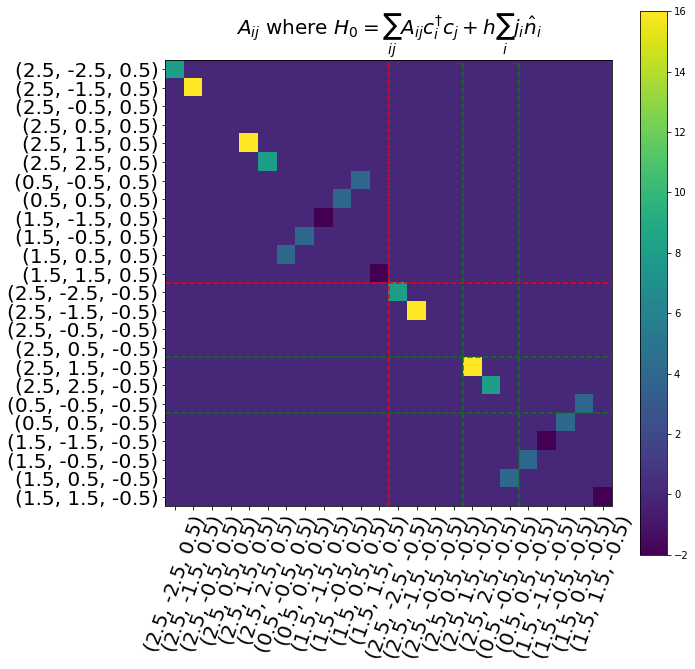

-7.999999999999997


In [61]:
omega=0
omega_b=4

InitialHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b)

kinetic_term:Dict={}
adj_matrix=np.zeros((size_a+size_b,size_a+size_b))

#cki
j_values=[1/2,3/2]


mj_list=[]
for a in range(energies.shape[0]):
    for b in range(energies.shape[0]):
        (na,la,ja,ma,ta,tza)=SPS.state_encoding[a]
        (nb,lb,jb,mb,tb,tzb)=SPS.state_encoding[b]
        
        # if ja==1.5 and ma==0.5 and jb==0.5 and mb==-0.5 and tza==tzb:
        #     kinetic_term[(a,b)]=omega
        #     kinetic_term[(b,a)]=omega
        #     adj_matrix[a,b]=omega
        #     adj_matrix[b,a]=omega
        
        # if ja==0.5 and ma==0.5 and jb==1.5 and mb==-0.5 and tza==tzb:
        #     kinetic_term[(a,b)]=omega
        #     kinetic_term[(b,a)]=omega
        #     adj_matrix[a,b]=omega
        #     adj_matrix[b,a]=omega
        
        if ja==2.5 and ma==1.5 and jb==1.5 and mb==-1.5 and tza==tzb:
            kinetic_term[(a,b)]=omega
            kinetic_term[(b,a)]=omega
            adj_matrix[a,b]=omega
            adj_matrix[b,a]=omega

        if ja==1.5 and ma==1.5 and jb==2.5 and mb==-1.5 and tza==tzb:
            kinetic_term[(a,b)]=omega
            kinetic_term[(b,a)]=omega
            adj_matrix[a,b]=omega
            adj_matrix[b,a]=omega

        if ja==1.5 and ma==0.5 and jb==0.5 and mb==-0.5 and tza==tzb:
            kinetic_term[(a,b)]=omega_b
            kinetic_term[(b,a)]=omega_b
            adj_matrix[a,b]=omega_b
            adj_matrix[b,a]=omega_b

        if ja==0.5 and ma==0.5 and jb==1.5 and mb==-0.5 and tza==tzb:
            kinetic_term[(a,b)]=omega_b
            kinetic_term[(b,a)]=omega_b
            adj_matrix[a,b]=omega_b
            adj_matrix[b,a]=omega_b


                
external_field=np.zeros(size_a+size_b)
rand=np.random.uniform(0,1,3)
rand_dict={1/2:rand[0],-1/2:rand[1]}
for i in range(size_a+size_b):
    (ni,li,ji,mi,ti,tzi)=SPS.state_encoding[i]
    j=SPS.get_index((ni,li,ji,-mi,ti,tzi))
    # if ji==1.5 and (mi)==0.5:
    #     external_field[i]=0
    # if ji==0.5 and (mi)==-0.5:
    #     external_field[i]=0
        
    # if ji==1.5 and (mi)==-0.5:
    #     external_field[i]=0
    if ji==0.5 and (mi)==0.5:
        external_field[i]=0.
        
    if ji==2.5 and np.abs(mi)==1.5:
        external_field[i]=2*omega_b
        
    
    # if ji==2.5 and mi==1.5:
    #     external_field[i]=0
        
    # if ji==2.5 and mi==-1.5:
    #     external_field[i]=0
    
    # if ji==1.5 and mi==0.5:
    #     external_field[i]=0
        
    # if ji==1.5 and mi==-0.5:
    #     external_field[i]=0
        
    # if ji==2.5 and mi==0.5:
    #     external_field[i]=0
        
    # if ji==2.5 and mi==-0.5:
    #     external_field[i]=0
        
    if ji==2.5 and np.abs(mi)==2.5:
        external_field[i]=2*omega_b
    
    if ji==2.5 and np.abs(mi)==1.5:
        external_field[i]=4*omega_b
    
    
    if ji==1.5 and np.abs(mi)==1.5:
        external_field[i]=-omega_b/2

    

        
        
    
        
    

    
    #external_field[i] = SPS.energies[i]


InitialHamiltonian.get_kinetic_operator(adj_matrix=kinetic_term)
InitialHamiltonian.get_external_potential(external_field)
InitialHamiltonian.get_hamiltonian()

nlevels=8

es,psis=InitialHamiltonian.get_spectrum(n_states=nlevels)
einitial=es[0]
psi_initial=psis[:,0]
print('total_m=',SPS.compute_m_exp_value(psi=psi_initial,basis=InitialHamiltonian.basis))
#print('total J^2=',psi_initial.transpose().conjugate() @ Joperator.hamiltonian @ psi_initial)
plt.figure(figsize=(10,10))

plt.title(r'$A_{ij}$ where $H_0=\sum_{ij}A_{ij} c^{\dagger}_i c_j + h \sum_i j_i \hat{n}_i$',fontsize=20)
plt.imshow(adj_matrix+np.eye(energies.shape[0])*external_field[None,:])
plt.xticks(np.arange(diag_m.shape[0]),label,rotation=70)
plt.yticks(np.arange(diag_m.shape[0]),label)
plt.colorbar()
plt.savefig('images/fig4')
plt.tick_params(which='major',labelsize=20)
plt.axhline(y=energies.shape[0]//2-0.5,color='red',linestyle='--')
plt.axvline(x=energies.shape[0]//2-0.5,color='red',linestyle='--')

plt.axhline(y=energies.shape[0]-5.5,color='green',linestyle='--')
plt.axvline(x=energies.shape[0]-5.5,color='green',linestyle='--')


plt.axhline(y=energies.shape[0]-8.5,color='green',linestyle='--')
plt.axvline(x=energies.shape[0]-8.5,color='green',linestyle='--')

plt.show()

print(einitial)

#### Final Driver Hamiltonian 

In [42]:
# We select the product state of the basis that minimizes the Hamiltonian
# min = 10000
# min_b=0.
# for i, b in enumerate(TargetHamiltonian.basis):
#     psi = np.zeros(TargetHamiltonian.basis.shape[0])
#     psi[i] = 1.0
#     value = np.conj(psi) @ TargetHamiltonian.hamiltonian @ psi
#     if value <= min:
#         min = value
#         print(value)
#         print(b)
#         psi_base = psi
#         min_b=b
        
        
min_b=np.zeros(size_a+size_b)
min_b[0]=1
min_b[5]=1
min_b[2]=1
min_b[3]=1

min_b[0+size_a]=1
min_b[5+size_a]=1
min_b[2+size_a]=1
min_b[3+size_a]=1



total_m= 7.132005837570874e-31


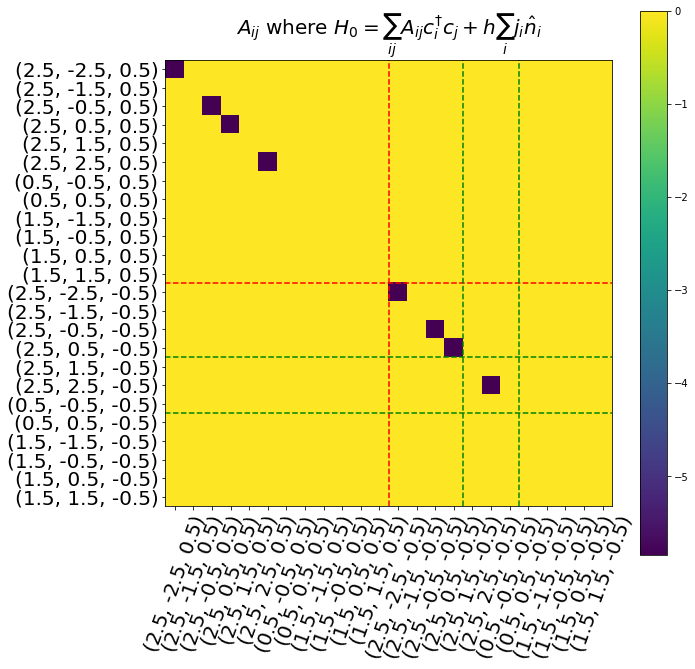

-23.364521036396994


In [54]:
omega=0
omega_b=4

InitialHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])

kinetic_term:Dict={}
adj_matrix=np.zeros((size_a+size_b,size_a+size_b))





                
external_field=np.zeros(size_a+size_b)
rand=np.random.uniform(0,1,3)
rand_dict={1/2:rand[0],-1/2:rand[1]}

external_field=min_b*energies-(nparticles_a+nparticles_b)*average_unit_energy*min_b

        
    
        
    

    
    #external_field[i] = SPS.energies[i]


InitialHamiltonian.get_external_potential(external_field)
InitialHamiltonian.get_hamiltonian()

nlevels=8

es,psis=InitialHamiltonian.get_spectrum(n_states=nlevels)
einitial=es[0]
psi_initial=psis[:,0]
print('total_m=',SPS.compute_m_exp_value(psi=psi_initial,basis=InitialHamiltonian.basis))
#print('total J^2=',psi_initial.transpose().conjugate() @ Joperator.hamiltonian @ psi_initial)
plt.figure(figsize=(10,10))

plt.title(r'$A_{ij}$ where $H_0=\sum_{ij}A_{ij} c^{\dagger}_i c_j + h \sum_i j_i \hat{n}_i$',fontsize=20)
plt.imshow(adj_matrix+np.eye(energies.shape[0])*external_field[None,:])
plt.xticks(np.arange(diag_m.shape[0]),label,rotation=70)
plt.yticks(np.arange(diag_m.shape[0]),label)
plt.colorbar()
plt.savefig('images/fig4')
plt.tick_params(which='major',labelsize=20)
plt.axhline(y=energies.shape[0]//2-0.5,color='red',linestyle='--')
plt.axvline(x=energies.shape[0]//2-0.5,color='red',linestyle='--')

plt.axhline(y=energies.shape[0]-5.5,color='green',linestyle='--')
plt.axvline(x=energies.shape[0]-5.5,color='green',linestyle='--')


plt.axhline(y=energies.shape[0]-8.5,color='green',linestyle='--')
plt.axvline(x=energies.shape[0]-8.5,color='green',linestyle='--')

plt.show()

print(einitial)

#### Single Particle Hamiltonian

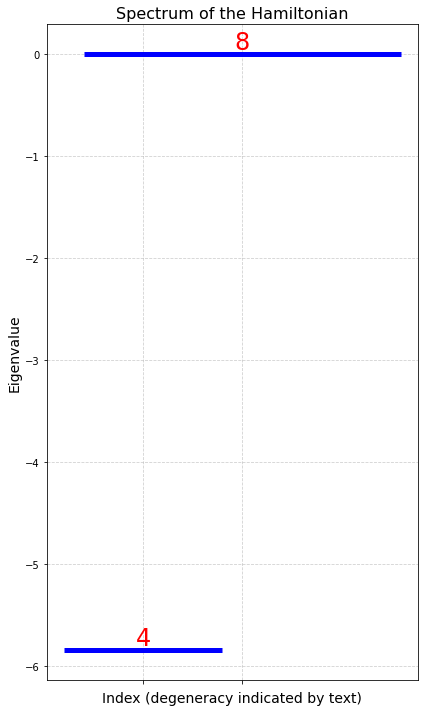

[-5.84113026 -5.84113026 -5.84113026 -5.84113026  0.          0.
  0.          0.          0.          0.          0.          0.        ]
component= (2.5, -2.5, 0.5) value= 0.0 

component= (2.5, -1.5, 0.5) value= 1.0 

component= (2.5, -0.5, 0.5) value= 0.0 

component= (2.5, 0.5, 0.5) value= 0.0 

component= (2.5, 1.5, 0.5) value= 0.0 

component= (2.5, 2.5, 0.5) value= 0.0 

component= (0.5, -0.5, 0.5) value= 0.0 

component= (0.5, 0.5, 0.5) value= 0.0 

component= (1.5, -1.5, 0.5) value= 0.0 

component= (1.5, -0.5, 0.5) value= 0.0 

component= (1.5, 0.5, 0.5) value= 0.0 

component= (1.5, 1.5, 0.5) value= 0.0 



In [15]:
single_particle_hamiltonian=adj_matrix[:size_a,:size_a]+external_field[:size_a,None]*np.eye(size_a)


eigenvalues,states=np.linalg.eigh(single_particle_hamiltonian)

plot_spectrum(eigenvalues)
print(eigenvalues)
nstate=0
for i in range(len(label[:size_a])):
    print('component=',label[i],'value=',states[i,nstate],'\n')


### $n_i$ expectation value

In [ ]:
n_expectation=np.zeros((nlevels,size_a+size_b))

for j in range(nlevels):
    for i in range(size_a+size_b):
        
        op=InitialHamiltonian.adag_a_matrix(i=i,j=i)
        n_expectation[j,i]=( (psis[:,j].conjugate().transpose() @ op @ psis[:,j]))


m_expectation=[]
j_expectation=[]
jdiag_expectation=[]
for j in range(nlevels):
    op=Moperator.hamiltonian
    op_j=Joperator.hamiltonian
    op_jdiag=Jdiagoperator.hamiltonian
    m_expectation.append( (psis[:,j].conjugate().transpose() @ op @ psis[:,j]))
    j_expectation.append((psis[:,j].conjugate().transpose() @ op_j @ psis[:,j]))
    jdiag_expectation.append((psis[:,j].conjugate().transpose() @ op_j @ psis[:,j]))

        
        
        





Plot

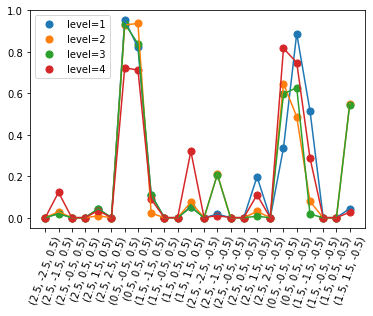

[-12.         -10.47213595 -10.47213595 -10.47213595 -10.47213595
  -8.94427191  -8.82842712  -8.82842712]
[]
[]
31.99999999999996


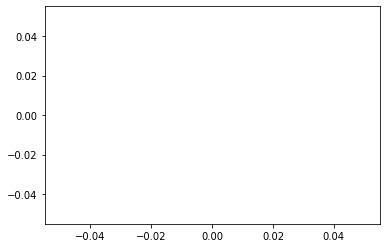

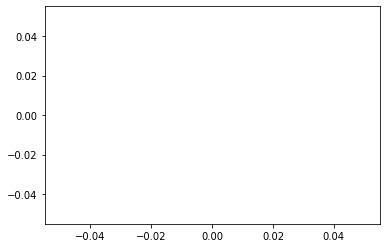

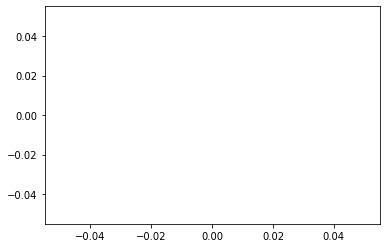

In [185]:
for i in range(1,5):
    plt.plot(n_expectation[i])
    plt.scatter(np.arange(energies.shape[0]),n_expectation[i],s=50,label=f'level={i}')
    plt.xticks(np.arange(energies.shape[0]),label,rotation=70)
    
plt.legend()
plt.show()

print(es)
print(m_expectation)
print(j_expectation)
print(np.sum(n_expectation))

plt.plot(j_expectation)
plt.show()

plt.plot(m_expectation)
plt.show()

plt.plot(jdiag_expectation)
plt.show()



##### Correlation function

In [8]:
correlation_matrix=np.zeros((size_a+size_b,size_a+size_b))
for i in range(size_a):
    for j in range(size_a):
        op=InitialHamiltonian.adag_a_matrix(i=i,j=j)
        print(op,i,j,'\n')
        correlation_matrix[j,i]=( (psis[:,0].conjugate().transpose() @ op @ psis[:,0]))
        
for i in range(size_a,size_a+size_b):
    for j in range(size_a,size_a+size_b):
        op=InitialHamiltonian.adag_a_matrix(i=i,j=j)
        correlation_matrix[j,i]=( (psis[:,0].conjugate().transpose() @ op @ psis[:,0]))


  (0, 0)	1.0
  (1, 1)	1.0
  (2, 2)	1.0
  (3, 3)	1.0
  (4, 4)	1.0
  (5, 5)	1.0
  (6, 6)	1.0
  (7, 7)	1.0
  (8, 8)	1.0
  (9, 9)	1.0
  (10, 10)	1.0
  (11, 11)	1.0
  (12, 12)	1.0
  (13, 13)	1.0
  (14, 14)	1.0
  (15, 15)	1.0
  (16, 16)	1.0
  (17, 17)	1.0
  (18, 18)	1.0
  (19, 19)	1.0
  (20, 20)	1.0
  (21, 21)	1.0
  (22, 22)	1.0
  (23, 23)	1.0
  (24, 24)	1.0
  (25, 25)	1.0
  (26, 26)	1.0
  (27, 27)	1.0
  (28, 28)	1.0
  (29, 29)	1.0
  (30, 30)	1.0
  (31, 31)	1.0
  (32, 32)	1.0
  (33, 33)	1.0
  (34, 34)	1.0
  (35, 35)	1.0
  (36, 36)	1.0
  (37, 37)	1.0
  (38, 38)	1.0
  (39, 39)	1.0
  (40, 40)	1.0
  (41, 41)	1.0
  (42, 42)	1.0
  (43, 43)	1.0
  (44, 44)	1.0
  (45, 45)	1.0
  (46, 46)	1.0
  (47, 47)	1.0
  (48, 48)	1.0
  (49, 49)	1.0
  (50, 50)	1.0
  (51, 51)	1.0
  (52, 52)	1.0
  (53, 53)	1.0
  (54, 54)	1.0
  (55, 55)	1.0
  (56, 56)	1.0
  (57, 57)	1.0
  (58, 58)	1.0
  (59, 59)	1.0
  (60, 60)	1.0
  (61, 61)	1.0
  (62, 62)	1.0
  (63, 63)	1.0
  (64, 64)	1.0
  (65, 65)	1.0
  (66, 66)	1.0
  (67, 67)	1.0


Plot

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23]),
 [Text(0, 0, '(2.5, -2.5, 0.5)'),
  Text(1, 0, '(2.5, -1.5, 0.5)'),
  Text(2, 0, '(2.5, -0.5, 0.5)'),
  Text(3, 0, '(2.5, 0.5, 0.5)'),
  Text(4, 0, '(2.5, 1.5, 0.5)'),
  Text(5, 0, '(2.5, 2.5, 0.5)'),
  Text(6, 0, '(0.5, -0.5, 0.5)'),
  Text(7, 0, '(0.5, 0.5, 0.5)'),
  Text(8, 0, '(1.5, -1.5, 0.5)'),
  Text(9, 0, '(1.5, -0.5, 0.5)'),
  Text(10, 0, '(1.5, 0.5, 0.5)'),
  Text(11, 0, '(1.5, 1.5, 0.5)'),
  Text(12, 0, '(2.5, -2.5, -0.5)'),
  Text(13, 0, '(2.5, -1.5, -0.5)'),
  Text(14, 0, '(2.5, -0.5, -0.5)'),
  Text(15, 0, '(2.5, 0.5, -0.5)'),
  Text(16, 0, '(2.5, 1.5, -0.5)'),
  Text(17, 0, '(2.5, 2.5, -0.5)'),
  Text(18, 0, '(0.5, -0.5, -0.5)'),
  Text(19, 0, '(0.5, 0.5, -0.5)'),
  Text(20, 0, '(1.5, -1.5, -0.5)'),
  Text(21, 0, '(1.5, -0.5, -0.5)'),
  Text(22, 0, '(1.5, 0.5, -0.5)'),
  Text(23, 0, '(1.5, 1.5, -0.5)')])

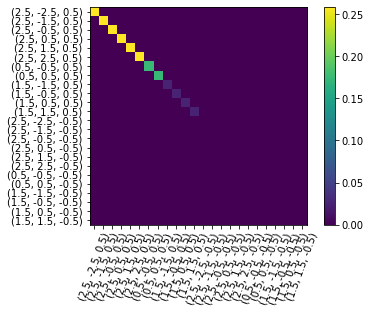

In [50]:
plt.imshow(correlation_matrix)
plt.colorbar()
plt.xticks(np.arange(energies.shape[0]),label,rotation=70)
plt.yticks(np.arange(energies.shape[0]),label)
plt.xticks()

#### Annealing

100%|██████████| 100/100 [00:13<00:00,  7.60it/s]


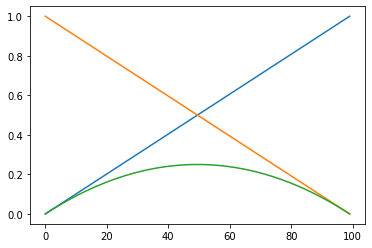

In [55]:
ngrid=100
nlevels=10
lambd=np.linspace(0,1.,ngrid)

spectrum=np.zeros((nlevels,ngrid))
psi_spectrum = np.zeros((nlevels, InitialHamiltonian.basis.shape[0]))
n_evolution=np.zeros((nlevels,ngrid, InitialHamiltonian.basis.shape[-1]))
j_values=np.zeros_like(spectrum)
m_values = np.zeros_like(spectrum)
comm=np.zeros_like(spectrum)
plt.plot(lambd)
plt.plot(1-lambd)
plt.plot(lambd*(1-lambd))

for i in trange(ngrid):

    ham=lambd[i]*TargetHamiltonian.hamiltonian+(1-lambd[i])*InitialHamiltonian.hamiltonian#+lambd[i]*(1-lambd[i])*IntermediateHamiltonian.hamiltonian   

    values,psis=eigsh(ham,k=nlevels,which='SA')
    for a in range(psis.shape[-1]):    
        #j_values[a,i]=psis[:,a].conjugate().transpose() @ Joperator.hamiltonian @ psis[:,a]
        m_values[a, i] = SPS.compute_m_exp_value(psi=psis[:,a],basis=InitialHamiltonian.basis)
        # for r in range(size_a+size_b):
    
        #     op=InitialHamiltonian.adag_a_matrix(i=r,j=r)
        #     n_evolution[a,i,r]= (psis[:,a].conjugate().transpose() @ op @ psis[:,a])


    spectrum[:,i]=values
    psi_spectrum=psis

Plots

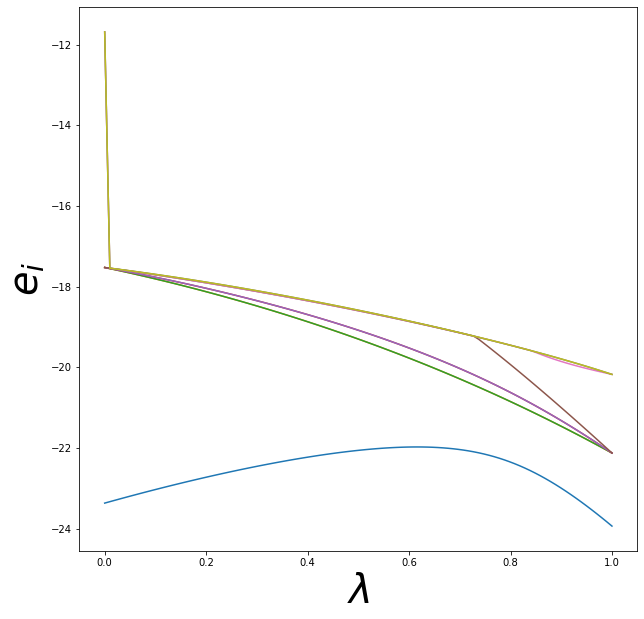

2.1853910854904885
-23.93429270827932


In [56]:
plt.figure(figsize=(10,10))
for i in range(0,9):
    plt.plot(lambd,spectrum[i])
# plt.xlim([0.9,1])
#plt.axhline(y=egs, color="red", linewidth=3, linestyle="--")
plt.xlabel(r'$\lambda$',fontsize=40)
plt.ylabel(r'$e_i$',fontsize=40)


plt.show()

t_critic=np.argmax(spectrum[0])
gap=np.min(np.abs(spectrum[1,:]-spectrum[0,:]))
print((gap**2))
print(spectrum[0,-1])

M and commutators

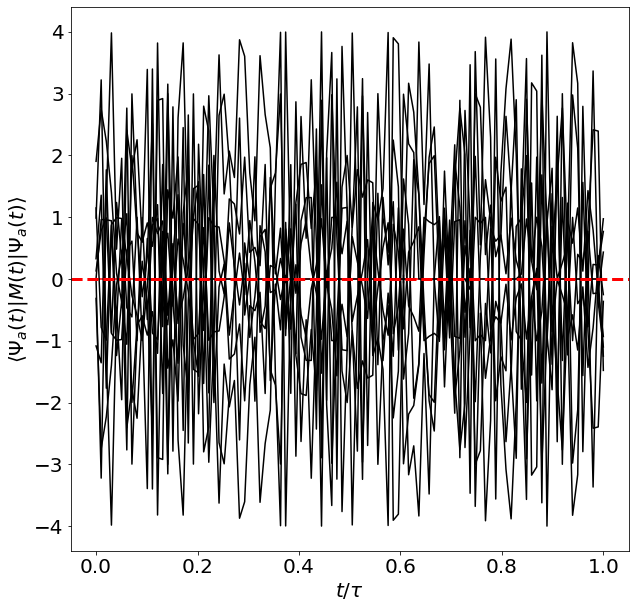

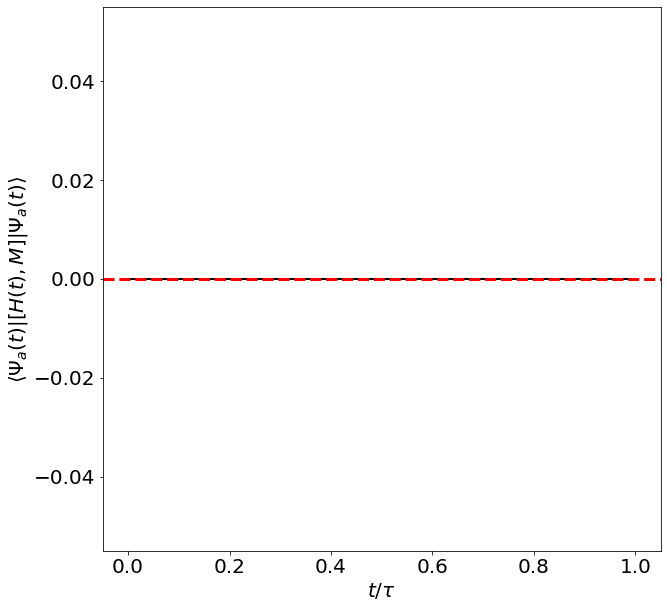

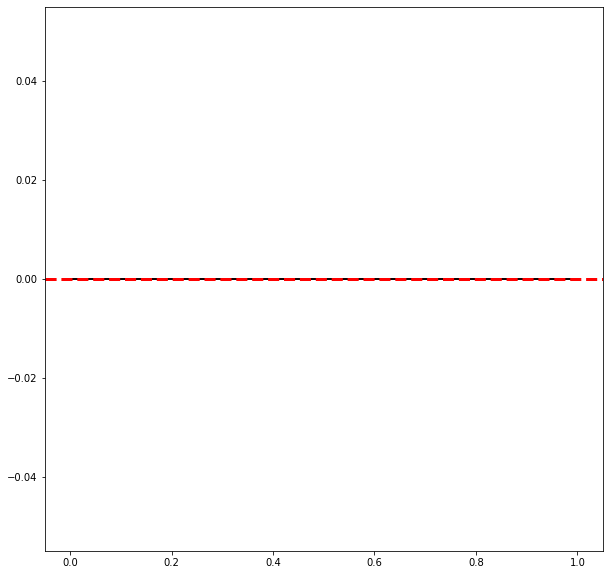

In [20]:



plt.figure(figsize=(10, 10))
plt.plot(lambd,m_values[0],color='red')
for i in range(1,10):
    plt.plot(lambd, m_values[i],color='black')
plt.axhline(y=0,color='red',linestyle='--',linewidth=3)
plt.xlabel(r'$t/\tau$',fontsize=20)
plt.ylabel(r'$\langle \Psi_a (t) | M(t) | \Psi_a (t) \rangle$',fontsize=20)
plt.tick_params(which='major',labelsize=20)

# plt.xlim([0.9,1])
plt.show()

plt.figure(figsize=(10, 10))
plt.plot(lambd,comm[0],color='red')
for i in range(1,10):
    plt.plot(lambd, comm[i],color='black')

plt.xlabel(r'$t/\tau$',fontsize=20)
plt.ylabel(r'$\langle \Psi_a (t) | [H(t),M] |\Psi_a (t) \rangle$',fontsize=20)
plt.axhline(y=0,color='red',linestyle='--',linewidth=3)
plt.tick_params(which='major',labelsize=20)

# plt.xlim([0.9,1])
plt.show()

plt.figure(figsize=(10, 10))
plt.plot(lambd,j_values[0],color='red')
for i in range(1,3):
    plt.plot(lambd, j_values[i],color='black')
plt.axhline(y=0,color='red',linestyle='--',linewidth=3)
# plt.xlim([0.9,1])
plt.show()

#### n particle number

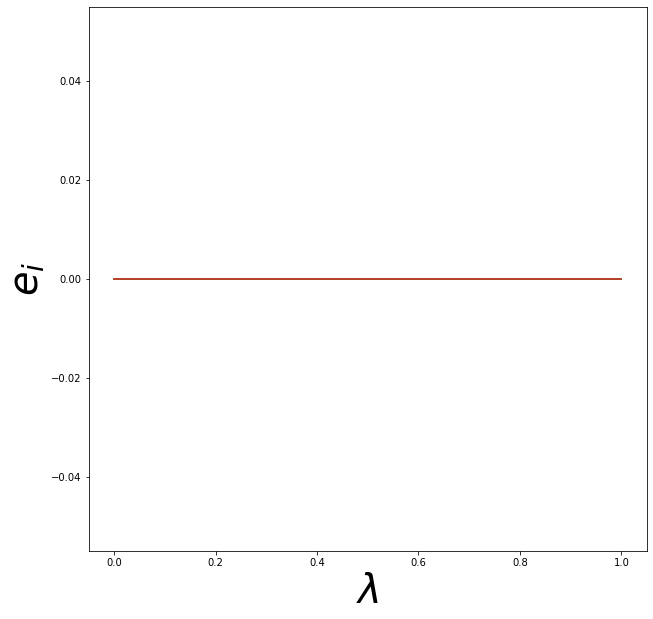

In [21]:
plt.figure(figsize=(10,10))
for r in range(energies.shape[0]):
    for i in range(1):
        plt.plot(lambd,n_evolution[i,:,r],label=f'state={r}')
        
# plt.xlim([0.9,1])
#plt.axhline(y=egs, color="red", linewidth=3, linestyle="--")
plt.xlabel(r'$\lambda$',fontsize=40)
plt.ylabel(r'$e_i$',fontsize=40)

plt.show()

##### Time Evolution

In [57]:
nstep =100
tf = 10/average_unit_energy
nlevels=10
time = np.linspace(0.0, tf, nstep)
psi = psi_initial
spectrum = np.zeros((nlevels, nstep))
probabilities=np.zeros((nlevels, nstep))
dt=time[1]-time[0]
eng_t=[]
variance_t=[]
fidelity_t=[]
lambd=1-time/tf
#gamma=1/(tf/2)
#lambd=np.exp(-gamma*time)
for i in trange(nstep):

    time_hamiltonian = (
        InitialHamiltonian.hamiltonian * ( lambd[i])
        + TargetHamiltonian.hamiltonian * (1-lambd[i])
    ) #+lambd[i]*(1-lambd[i]) * IntermediateHamiltonian.hamiltonian
    values, psis = eigsh(time_hamiltonian, k=nlevels, which="SA")
    psi=expm_multiply(-1j*dt*time_hamiltonian,psi)

    e_ave=psi.conjugate().transpose()@ time_hamiltonian @ psi
    e_square_ave = (
        psi.conjugate().transpose() @ time_hamiltonian @ time_hamiltonian @ psi
    )
    eng_t.append(e_ave)
    variance_t.append(e_square_ave-e_ave**2)
    spectrum[:, i] = values

    degenerate_fidelity=0.
    count=0
    for j in range(values.shape[0]):
        if np.isclose(values[j],values[0]):
            degenerate_fidelity += (
                psis[:, j].conjugate().transpose() @ psi[:]
            ) * np.conj(psis[:, j].conjugate().transpose() @ psi[:])
            count=count+1
        
        probabilities[j,i]=(
                psis[:, j].conjugate().transpose() @ psi[:]
            ) * np.conj(psis[:, j].conjugate().transpose() @ psi[:])

    fidelity=degenerate_fidelity        
    fidelity_t.append(fidelity)

eng_t=np.asarray(eng_t)
fidelity_t=np.asarray(fidelity_t)
variance_t=np.asarray(variance_t)
print(np.abs((egs-eng_t[-1])/egs))
print(fidelity)
print(eng_t.shape)

  0%|          | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_3482620/4055304986.py:41: ComplexWarning: Casting complex values to real discards the imaginary part
  probabilities[j,i]=(
100%|██████████| 100/100 [00:06<00:00, 15.44it/s]

[6.49333876e-05]
(0.9995399919513503+0j)
(100,)


#### Analysis of the different initial configuration

In [63]:
fidelity_different_initial_state=[]

labels_psis=[r'$|\Psi_{ref}\rangle$',r'$|\Psi_{1}\rangle$',r'$|\Psi_{2} \rangle$']

$\ket{\Psi_{ref}}=$ minimum basis element, $\ket{\Psi_1}=\ket{1_{m=\pm 3/2,j=5/2},1_{m=\pm 5/2,j=5/2}}$, $\ket{\Psi_2}=\ket{1_{m=\pm 1/2,j=5/2},1_{m=\pm 5/2,j=5/2}}$

In [59]:
# save the fidelity

fidelity_different_initial_state.append(fidelity_t[-1])

/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


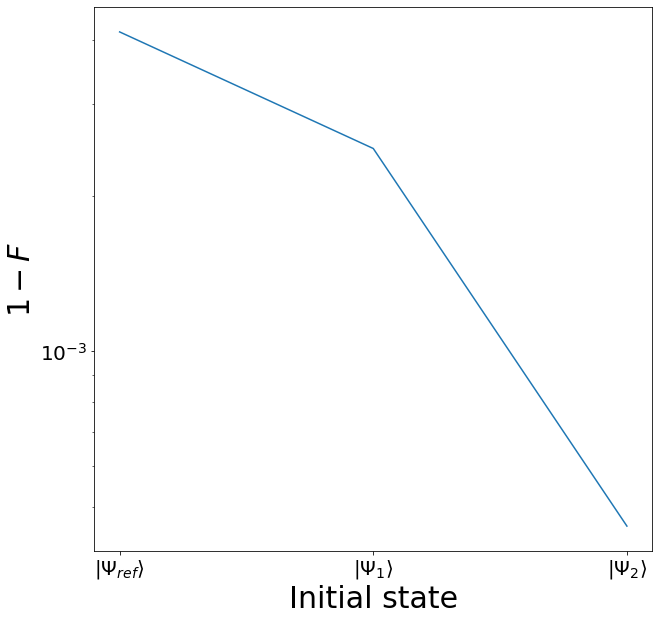

In [67]:
plt.figure(figsize=(10,10))
plt.plot(1-np.asarray(fidelity_different_initial_state[:-1],linewidth=4))
plt.scatter(np.arange(3),1-np.asarray(fidelity_different_initial_state[:-1],s=100))
plt.semilogy()
plt.xticks(np.arange(3),labels_psis)
plt.xlabel('Initial state',fontsize=30)
plt.ylabel(r'$1-F$',fontsize=30)
plt.tick_params(which='major',labelsize=20)
plt.show()

In [ ]:
levels_studied=10
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list('transparency_to_black', [(0, 0, 0, 0), (0, 0, 0, 1)])
fig=plt.figure(figsize=(10,10))

print(eng_t.shape,egs.shape)
plt.figure(figsize=(10, 10))
print(probabilities[-1])
tot_scatters=[]

probs=probabilities[:levels_studied]

print(probabilities[1])
norm = plt.Normalize(probabilities.min(), probabilities.max())
for i in range(0,levels_studied):
    plt.plot(time, spectrum[i],color='red')

for i in range(0,levels_studied):
    plt.scatter(time, spectrum[i],c=probabilities[i],cmap=cmap,norm=norm,s=20)

#gs_scatter=plt.scatter(time,eng_t[:,0,0],c=probabilities[0,:],linestyle='--',linewidth=3,cmap='viridis',norm=norm)
#tot_scatters.append(gs_scatter)

colorbar=plt.colorbar()
colorbar.set_label('Population',fontsize=20)

print(fidelity.shape)
# plt.xlim([0.9,1])
plt.xlabel(r'$t[1/\omega]$',fontsize=40)
plt.ylabel(r'$\langle \Psi(t)| H(t)| \Psi(t) \rangle$',fontsize=40)
plt.text(x=tf*1/5,y=eng_t[-1]+9,s=r'$F(\tau)=$'+f'{fidelity.real:.3f}',fontsize=30)
plt.text(x=tf * 1 / 5, y=eng_t[-1]+6, s=r"$\Delta_r e=$" + f"{(eng_t[-1].real-egs[0])/egs[0]:.5f}", fontsize=30)

plt.text(
    x=tf * 1 / 5,
    y=eng_t[-1]+3,
    s=r"$N_p=$" + f"{nparticles_a} " + r"$N_n=$" + f"{nparticles_b}",
    fontsize=30,
)
plt.tick_params(which='major',labelsize=30)
plt.tick_params(which="minor", labelsize=30)
plt.savefig('images/fig2')
plt.show()




plt.plot(time, fidelity_t, color="red", linestyle="--", linewidth=3)
# plt.xlim([0.9,1])
plt.xlabel(r"$t[1/\omega]$", fontsize=40)
plt.ylabel(r"$F(t)$", fontsize=40)
plt.savefig('images/fig3')
plt.show()

#### Population plot

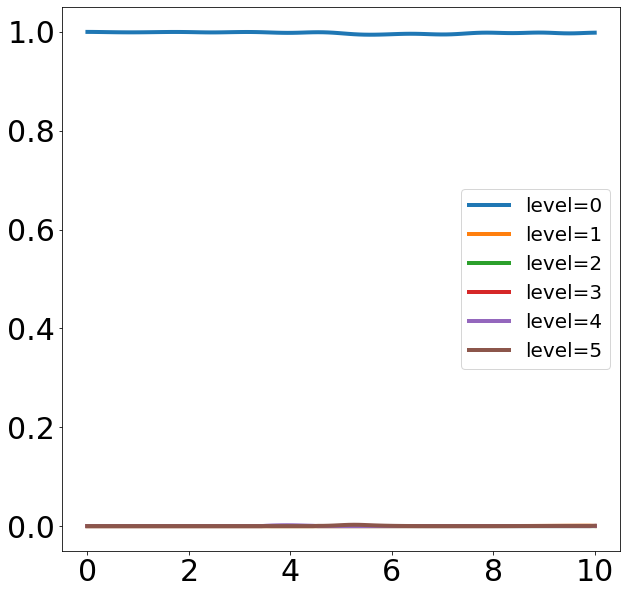

In [181]:
plt.figure(figsize=(10,10))
for i in range(6):
    
    plt.plot(time,probabilities[i],label=f'level={i}',linewidth=4)

plt.legend(fontsize=20)
plt.tick_params(which='major',labelsize=30)
plt.show()

#### $\tau$ vs Fidelity

In [24]:
tfs = np.array([1,2,4,8,16,32,64])/average_unit_energy
nsteps =10*tfs
nlevels=10

#gamma=1/(tf/2)
#lambd=np.exp(-gamma*time)
fidelities=[]
relative_err=[]
for a in range(tfs.shape[0]):
    tf=tfs[a]
    nstep=int(nsteps[a])
    time = np.linspace(0.0, tf, nstep)
    psi = psi_initial
    dt=time[1]-time[0]
    lambd=1-time/tf
    for i in trange(nstep):

        time_hamiltonian = (
            InitialHamiltonian.hamiltonian * ( lambd[i])
            + TargetHamiltonian.hamiltonian * (1-lambd[i])
        ) #+lambd[i]*(1-lambd[i]) * IntermediateHamiltonian.hamiltonian
        values, psis = eigsh(time_hamiltonian, k=nlevels, which="SA")
        psi=expm_multiply(-1j*dt*time_hamiltonian,psi)

        e_ave=psi.conjugate().transpose()@ time_hamiltonian @ psi
        e_square_ave = (
            psi.conjugate().transpose() @ time_hamiltonian @ time_hamiltonian @ psi
        )
        
    degenerate_fidelity=0.
    count=0
    for j in range(values.shape[0]):
        if np.isclose(values[j],values[0]):
            degenerate_fidelity += (
                psis[:, j].conjugate().transpose() @ psi[:]
            ) * np.conj(psis[:, j].conjugate().transpose() @ psi[:])
            count=count+1

    print('fidelity=',degenerate_fidelity,'relative energy error=',e_ave,'\n')
    fidelities.append(degenerate_fidelity)
    relative_err.append(np.abs((egs-e_ave)/egs))    


fidelities=np.asarray(fidelities)
relative_err=np.asarray(relative_err)


100%|██████████| 1336/1336 [01:13<00:00, 18.27it/s]


#### Plots

/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


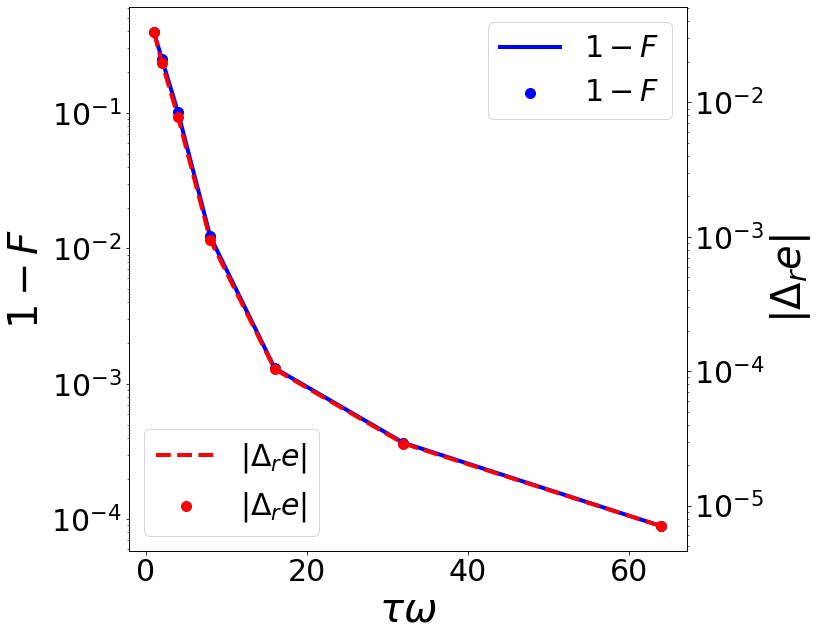

In [41]:
fig,ax=plt.subplots(figsize=(10,10))
ax.plot(tfs*average_unit_energy,1-fidelities,label=r'$1-F$',color='blue',linewidth=4,linestyle='-')
ax.scatter(tfs*average_unit_energy,1-fidelities,label=r'$1-F$',color='blue',s=100)
ax.semilogy()
ax.set_xlabel(r'$\tau \omega $',fontsize=40)
ax.set_ylabel(r'$1-F$',fontsize=40)
ax_twin=ax.twinx()
ax_twin.plot(tfs*average_unit_energy,relative_err,label=r'$|\Delta_r e|$',color='red',linewidth=4,linestyle='--')
ax_twin.scatter(tfs*average_unit_energy,relative_err,label=r'$|\Delta_r e|$',color='red',s=100)
ax.legend(fontsize=30)
ax_twin.semilogy()
ax_twin.legend(fontsize=30,loc='lower left')
ax_twin.set_ylabel('$|\Delta_r e|$',fontsize=40)
ax.tick_params(which='major',labelsize=30)
ax_twin.tick_params(which='major',labelsize=30)
plt.show()

#### Silicon Analysis

In [1]:
import numpy as np
import matplotlib.pyplot as plt

/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


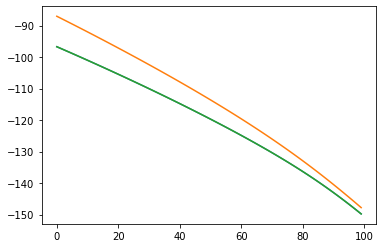

In [35]:
data=np.load('data/quantum_annealing_results/silicon_results_quantum_annealing.npz')

nparticles_a=6
nparticles_b=6
fidelity=data['fidelity']
spectrum=data['spectrum']
eng_t=data['energy']
probabilities=data['probabilities']
egs=data['egs']
time=np.linspace(0,10/average_unit_energy,eng_t.shape[0])
tf=10/average_unit_energy
for i in range(spectrum.shape[0]):
    plt.plot(spectrum[i])
plt.plot(eng_t)
plt.show()

(100,) (1,)
[4.36564145e-33 9.24048521e-07 1.06241526e-06 1.75461423e-08
 8.30402351e-07 1.30693486e-06 1.20537217e-07 6.12616169e-07
 1.55254466e-06 4.08316470e-07 2.95053978e-07 1.64938283e-06
 9.55423597e-07 3.91806836e-08 1.40001483e-06 1.66626098e-06
 1.71064235e-07 7.54766637e-07 2.12699725e-06 9.67490075e-07
 1.30761979e-07 1.77489892e-06 2.12711664e-06 3.97139594e-07
 6.82199020e-07 2.50623262e-06 1.85857507e-06 2.45807766e-07
 1.34114025e-06 2.95768870e-06 1.77789177e-06 3.71012887e-07
 1.81505593e-06 3.40756072e-06 2.14108081e-06 6.14939604e-07
 2.02502748e-06 4.02415886e-06 3.11393702e-06 1.07973764e-06
 1.94450878e-06 4.64773982e-06 4.78681275e-06 2.29386299e-06
 1.75317005e-06 4.66735001e-06 6.79795529e-06 5.03933745e-06
 2.58504977e-06 3.80461784e-06 7.60052782e-06 8.99623813e-06
 6.65834318e-06 4.39290610e-06 6.19735082e-06 1.07263780e-05
 1.30958041e-05 1.12712758e-05 8.21614041e-06 9.01332085e-06
 1.42305993e-05 1.95435543e-05 2.04731304e-05 1.73853758e-05
 1.51385495e

/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/text.py:831: ComplexWarning: Casting complex values to real discards the imaginary part
  y = float(self.convert_yunits(self._y))
/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/text.py:691: ComplexWarning: Casting complex values to real discards the imaginary part
  posy = float(self.convert_yunits(self._y))


<Figure size 720x720 with 0 Axes>

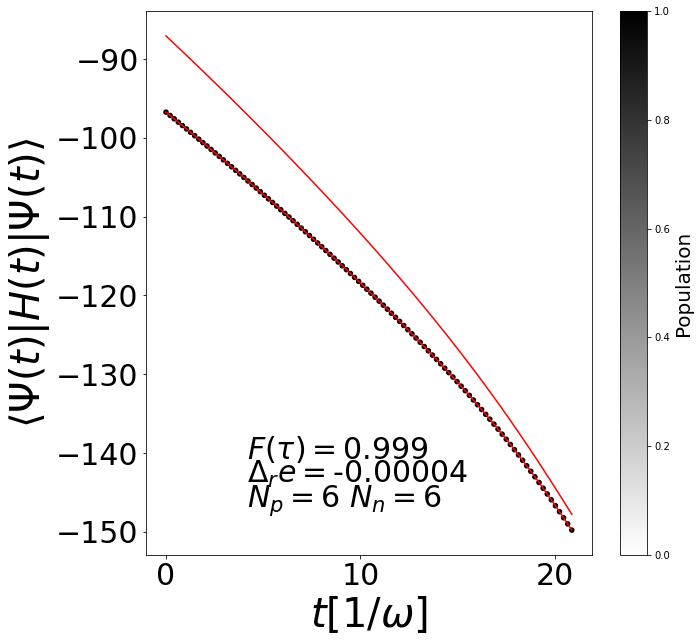

In [36]:
levels_studied=2
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list('transparency_to_black', [(0, 0, 0, 0), (0, 0, 0, 1)])
fig=plt.figure(figsize=(10,10))

print(eng_t.shape,egs.shape)
plt.figure(figsize=(10, 10))
print(probabilities[-1])
tot_scatters=[]

probs=probabilities[:levels_studied]

print(probabilities[1])
norm = plt.Normalize(probabilities.min(), probabilities.max())
for i in range(0,levels_studied):
    plt.plot(time, spectrum[i],color='red')

for i in range(0,levels_studied):
    plt.scatter(time, spectrum[i],c=probabilities[i],cmap=cmap,norm=norm,s=20)

#gs_scatter=plt.scatter(time,eng_t[:,0,0],c=probabilities[0,:],linestyle='--',linewidth=3,cmap='viridis',norm=norm)
#tot_scatters.append(gs_scatter)

colorbar=plt.colorbar()
colorbar.set_label('Population',fontsize=20)

print(fidelity.shape)
# plt.xlim([0.9,1])
plt.xlabel(r'$t[1/\omega]$',fontsize=40)
plt.ylabel(r'$\langle \Psi(t)| H(t)| \Psi(t) \rangle$',fontsize=40)
plt.text(x=tf*1/5,y=eng_t[-1]+9,s=r'$F(\tau)=$'+f'{fidelity[-1].real:.3f}',fontsize=30)
plt.text(x=tf * 1 / 5, y=eng_t[-1]+6, s=r"$\Delta_r e=$" + f"{(eng_t[-1].real-egs[0])/egs[0]:.5f}", fontsize=30)

plt.text(
    x=tf * 1 / 5,
    y=eng_t[-1]+3,
    s=r"$N_p=$" + f"{nparticles_a} " + r"$N_n=$" + f"{nparticles_b}",
    fontsize=30,
)
plt.tick_params(which='major',labelsize=30)
plt.tick_params(which="minor", labelsize=30)
plt.savefig('images/fig2')
plt.show()

/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


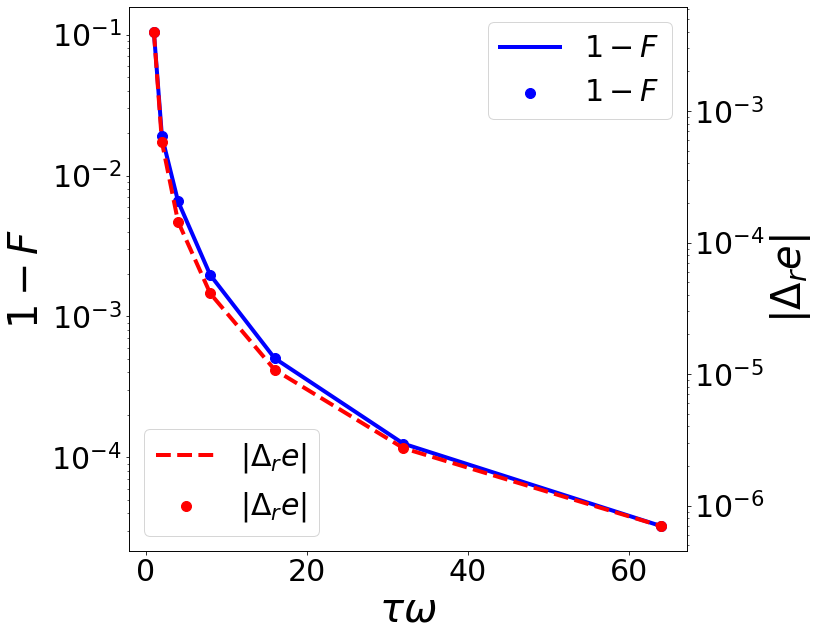

In [34]:
data=np.load('data/quantum_annealing_results/silicon_qa_results_fidelity_tau.npz')

fidelities=data['fidelity']
tfs=data['tau']
relative_err=data['relative_error']


fig,ax=plt.subplots(figsize=(10,10))
ax.plot(tfs*average_unit_energy,1-fidelities,label=r'$1-F$',color='blue',linewidth=4,linestyle='-')
ax.scatter(tfs*average_unit_energy,1-fidelities,label=r'$1-F$',color='blue',s=100)
ax.semilogy()
ax.set_xlabel(r'$\tau \omega $',fontsize=40)
ax.set_ylabel(r'$1-F$',fontsize=40)
ax_twin=ax.twinx()
ax_twin.plot(tfs*average_unit_energy,relative_err,label=r'$|\Delta_r e|$',color='red',linewidth=4,linestyle='--')
ax_twin.scatter(tfs*average_unit_energy,relative_err,label=r'$|\Delta_r e|$',color='red',s=100)
ax.legend(fontsize=30)
ax_twin.semilogy()
ax_twin.legend(fontsize=30,loc='lower left')
ax_twin.set_ylabel('$|\Delta_r e|$',fontsize=40)
ax.tick_params(which='major',labelsize=30)
ax_twin.tick_params(which='major',labelsize=30)
plt.show()